#### Importing Libraries

In [1]:
# import all libraries needed
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.optimizers import Adam, SGD, Adagrad, Adamax, RMSprop
from sklearn.metrics import classification_report
import os
import zipfile
import shutil
import splitfolders
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, GlobalMaxPool2D, SpatialDropout2D, BatchNormalization, AveragePooling2D, GlobalAvgPool2D, Dropout
from sklearn.preprocessing import LabelEncoder

In [3]:
data_dir = 'C:/TUGASKYU/SMT 7/Praktikum Machine Learning/dataset'
output = 'C:/TUGASKYU/SMT 7/Praktikum Machine Learning/dataset_split'
splitfolders.ratio(data_dir, output=output, seed=42, ratio=(0.8,0.2)) 

Copying files: 13808 files [01:39, 139.34 files/s]


In [4]:
train_dir = os.path.join('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/dataset_split/train')
validation_dir = os.path.join('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/dataset_split/val')

In [6]:
# gather train dataset
trainX = []
trainY = []
for r, d, f in os.walk(train_dir):
    for file in f:
        if ".png" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            trainX.append(image)
            label = imagePath.split(os.path.sep)[-2]
            trainY.append(label)

trainX = np.array(trainX)
trainY = np.array(trainY)

In [7]:
# gather validation data
valX = []
valY = []
for r, d, f in os.walk(validation_dir):
    for file in f:
        if ".png" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (150,150))
            valX.append(image)
            label = imagePath.split(os.path.sep)[-2]
            valY.append(label)

valX = np.array(valX)
valY = np.array(valY)

In [8]:
# check shape of each images in train & val dataset
print("Train Data=", trainX.shape)
print("Train Label=", trainY.shape)
print("Validation Data=", valX.shape)
print("Validation Label=", valY.shape) 

Train Data= (11045, 150, 150, 3)
Train Label= (11045,)
Validation Data= (2763, 150, 150, 3)
Validation Label= (2763,)


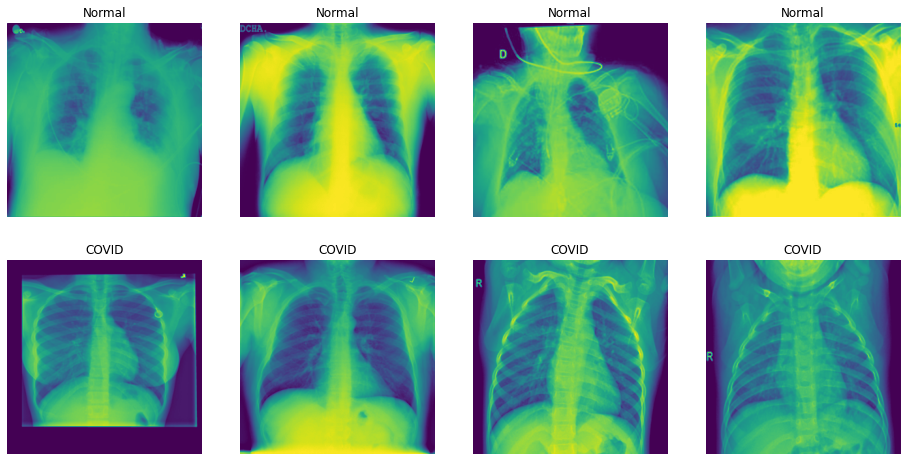

In [10]:
%matplotlib inline


train_COVID_dir = os.path.join('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/dataset_split/train/COVID')
train_Normal_dir = os.path.join('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/dataset_split/train/Normal')

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 2
ncols = 4

pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
pic_index += 4

next_COVID_pix = [os.path.join(train_COVID_dir, fname)
                        for fname in os.listdir(train_COVID_dir)[pic_index-4:pic_index]]
next_Normal_pix = [os.path.join(train_Normal_dir, fname)
                       for fname in os.listdir(train_Normal_dir)[pic_index-4:pic_index]]

for i, img_path in enumerate(next_COVID_pix+next_Normal_pix):
    # Set up subplot; subplot indices start at 1
    if(i < 4) :
        title = "Normal"
    else:
        title = "COVID"
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    plt.title(title)
    img = mpimg.imread(img_path)
    plt.imshow(img)


plt.show()

In [11]:
# label encoder implementation in each train & validation label
lb = LabelEncoder()
trainY = lb.fit_transform(trainY)
valY = lb.fit_transform(valY)

In [12]:
# normalize the scale in every images using ImageDataGenerator
datagen = ImageDataGenerator( rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  validation_split = 0.25)
# implement ImageDataGenerator in train, test data, & each label
train_iterator = datagen.flow(trainX, trainY, batch_size=64)
val_iterator = datagen.flow(valX, valY, batch_size=64)
print('Batches train=%d, validation=%d' % (len(train_iterator), len(val_iterator)))

Batches train=173, validation=44


In [13]:
# check maximum & minimum scale of each images
print('Train min=%.f, max=%.f' % (trainX.min(), trainX.max()))
print('Validation min=%.f, max=%.f' % (valX.min(), valX.max()))
     

Train min=0, max=255
Validation min=0, max=255


In [14]:
# check minimum & maximum scale after normalize each images
batchX, batchy = train_iterator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(64, 150, 150, 3), min=0.000, max=1.000


Model 1

In [33]:
# build a simple model
model = Sequential()
model.add(InputLayer(input_shape=[150, 150, 3]))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='elu'))
model.add(SpatialDropout2D(rate=0.5))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))

model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='elu'))
model.add(SpatialDropout2D(rate=0.5))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, padding='same'))

model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='elu'))
model.add(SpatialDropout2D(rate=0.5))
model.add(BatchNormalization())
model.add(GlobalMaxPool2D())
model.add(Flatten())

# fully connected
model.add(Dense(512, activation='elu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 spatial_dropout2d_11 (Spati  (None, 150, 150, 32)     0         
 alDropout2D)                                                    
                                                                 
 batch_normalization_12 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 75, 75, 64)        18496     
                                                      

In [34]:
# compile model
model.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
# training & saving history of every epoch
H = model.fit(train_iterator, epochs=100, steps_per_epoch=30, validation_data=val_iterator,verbose=1)

Epoch 1/100
30/30 [==============================] - 147s 5s/step - loss: 0.6034 - accuracy: 0.7110 - val_loss: 0.6233 - val_accuracy: 0.7412
Epoch 2/100
30/30 [==============================] - 146s 5s/step - loss: 0.5676 - accuracy: 0.7427 - val_loss: 0.6110 - val_accuracy: 0.7416
Epoch 3/100
30/30 [==============================] - 141s 5s/step - loss: 0.5925 - accuracy: 0.7203 - val_loss: 0.6131 - val_accuracy: 0.7445
Epoch 4/100
30/30 [==============================] - 146s 5s/step - loss: 0.5820 - accuracy: 0.7354 - val_loss: 0.6046 - val_accuracy: 0.7405
Epoch 5/100
30/30 [==============================] - 158s 5s/step - loss: 0.5692 - accuracy: 0.7458 - val_loss: 0.5973 - val_accuracy: 0.7398
Epoch 6/100
30/30 [==============================] - 144s 5s/step - loss: 0.5666 - accuracy: 0.7432 - val_loss: 0.5822 - val_accuracy: 0.7380
Epoch 7/100
30/30 [==============================] - 157s 5s/step - loss: 0.5731 - accuracy: 0.7365 - val_loss: 0.5769 - val_accuracy: 0.7380
Epoch 

In [37]:
model.save('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/Kelompok/Modul 2 Model 1.h5')

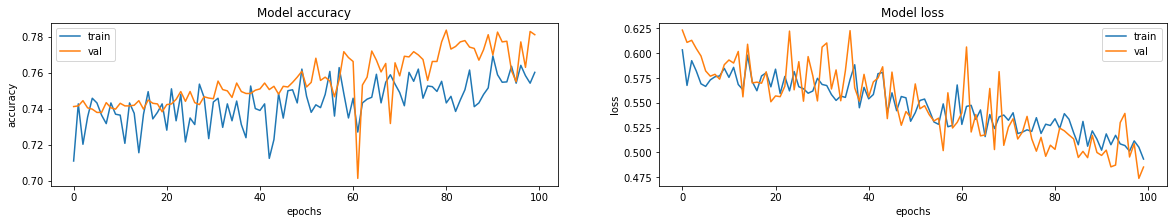

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(H.history[met])
    ax[i].plot(H.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [40]:
# classification report
pred = model.predict(trainX)
labels = (pred > 0.5).astype(np.int)
print(classification_report(trainY, labels))

346/346 [==============================] - 123s 355ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2892
           1       0.74      1.00      0.85      8153

    accuracy                           0.74     11045
   macro avg       0.37      0.50      0.42     11045
weighted avg       0.54      0.74      0.63     11045



<ipython-input-40-e60bd2374c68>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = (pred > 0.5).astype(np.int)
c:\Users\putri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\putri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision a

In [41]:
# build a simple model
model2 = Sequential()
model2.add(InputLayer(input_shape=[150, 150, 3]))
model2.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(SpatialDropout2D(rate=0.5))
model2.add(BatchNormalization())
model2.add(AveragePooling2D())

model2.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(SpatialDropout2D(rate=0.5))
model2.add(BatchNormalization())
model2.add(AveragePooling2D())

model2.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(SpatialDropout2D(rate=0.5))
model2.add(BatchNormalization())
model2.add(GlobalAvgPool2D())
model2.add(Flatten())

# fully connected
model2.add(Dense(512, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 spatial_dropout2d_14 (Spati  (None, 150, 150, 32)     0         
 alDropout2D)                                                    
                                                                 
 batch_normalization_15 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 average_pooling2d (AverageP  (None, 75, 75, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_15 (Conv2D)          (None, 75, 75, 64)        18496     
                                                      

In [43]:
model2.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
# training & saving history of every epoch
H2 = model2.fit(train_iterator, epochs=100, steps_per_epoch=30, validation_data=val_iterator, verbose=1)

Epoch 1/100
30/30 [==============================] - 110s 4s/step - loss: 0.5866 - accuracy: 0.7240 - val_loss: 0.5899 - val_accuracy: 0.7380
Epoch 2/100
30/30 [==============================] - 110s 4s/step - loss: 0.5681 - accuracy: 0.7401 - val_loss: 0.5818 - val_accuracy: 0.7380
Epoch 3/100
30/30 [==============================] - 110s 4s/step - loss: 0.5866 - accuracy: 0.7349 - val_loss: 0.5856 - val_accuracy: 0.7380
Epoch 4/100
30/30 [==============================] - 102s 3s/step - loss: 0.5736 - accuracy: 0.7391 - val_loss: 0.5748 - val_accuracy: 0.7380
Epoch 5/100
30/30 [==============================] - 102s 3s/step - loss: 0.5645 - accuracy: 0.7375 - val_loss: 0.5860 - val_accuracy: 0.7380
Epoch 6/100
30/30 [==============================] - 102s 3s/step - loss: 0.5586 - accuracy: 0.7484 - val_loss: 0.5862 - val_accuracy: 0.7387
Epoch 7/100
30/30 [==============================] - 101s 3s/step - loss: 0.5800 - accuracy: 0.7281 - val_loss: 0.6005 - val_accuracy: 0.7311
Epoch 

In [48]:
model2.save('C:/TUGASKYU/SMT 7/Praktikum Machine Learning/Kelompok/Modul 2 Model 2.h5')

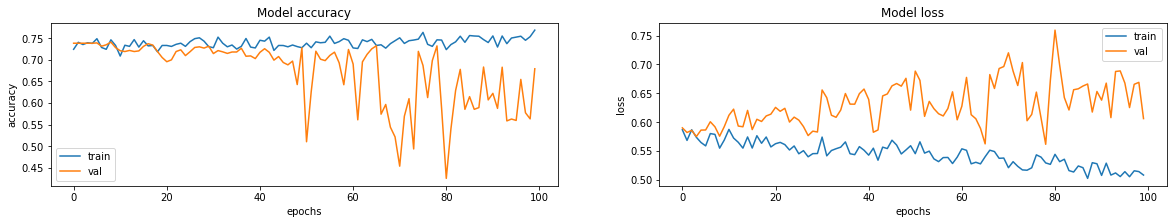

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(H2.history[met])
    ax[i].plot(H2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [51]:
# classification report
pred = model2.predict(trainX)
labels = (pred > 0.5).astype(np.int)
print(classification_report(trainY, labels))

346/346 [==============================] - 85s 244ms/step
              precision    recall  f1-score   support

           0       0.26      1.00      0.42      2892
           1       0.00      0.00      0.00      8153

    accuracy                           0.26     11045
   macro avg       0.13      0.50      0.21     11045
weighted avg       0.07      0.26      0.11     11045



<ipython-input-51-aa367d2d882d>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = (pred > 0.5).astype(np.int)
c:\Users\putri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\putri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision a